# Parameter Estimation - SIR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm, gaussian_kde
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-rate parameters: 
    b_samples = np.random.normal(-1.0, 0.25, size=(batch_size, 1))
    c_samples = np.random.normal(-1.5, 0.25, size=(batch_size, 1))
    p_samples = np.c_[b_samples, c_samples]
    return p_samples.astype(np.float32)

# ODE model for SIR dynamics
def sir_dynamics(t, x, theta):
    theta = 10**theta
    return np.array([
            -theta[0]*x[0]*x[1]/N, 
            theta[0]*x[0]*x[1]/N - theta[1]*x[1],
            theta[1]*x[1]
            ])

N = 1000   # population size
x0 = np.array([999, 1, 0])   # initial state       
sigma = 0.05   # noise standard deviation
t_end = 180
n_obs = 21
time_points = np.linspace(0, t_end, n_obs)
missing_max = 15

def batch_simulator_augment01(prior_samples, n_missing):  
    """
    Simulate multiple SIR model data sets with n_missing missing values and binary indicator augmentation
    """    
    n_sim = prior_samples.shape[0]   # batch size    
    sim_data = np.ones((n_sim, n_obs, 4), dtype=np.float32)   # 1 batch consisting of n_sim data sets, each with n_obs observations
    
    for m in range(n_sim):
        rhs = lambda t,x: sir_dynamics(t, x, prior_samples[m])
        sol = solve_ivp(rhs, t_span=(0, t_end), y0=x0, t_eval=time_points, atol=1e-9, rtol=1e-6)
        sim_data[m, :, 0:3] = sol.y.T/N + np.random.normal(0, sigma, size=(n_obs, 3))     # observable: y = x + N(0,sigma²)
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, -1.0, -1.0, 0.0])
        
    return sim_data   

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [4]:
# Augment by 0/1
summary_net = LSTM(128)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./SIR_augment01(-1)_5ACB_[64,64,64]_LSTM(128)_ckpts', skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./SIR_augment01(-1)_5ACB_[64,64,64]_LSTM(128)_ckpts\ckpt-300


## Generate test data

In [5]:
# Test data sets
param_priors = np.array([[-0.8, -1.4], [-1.0, -1.7], [-0.5, -1.3]])  
n_missings = np.array([15, 10, 5])
x_datas = batch_simulator_augment01(param_priors, n_missings)
np.save('x_datas.npy', x_datas)

In [6]:
# Load test data
param_priors = np.array([[-0.8, -1.4], [-1.0, -1.7], [-0.5, -1.3]])
x_datas = np.load("x_datas.npy")

## Computational faithfulness

In [7]:
# Sample from BayesFlow
n_post_samples = 2500 
param_samples = amortizer.sample(x_datas, n_post_samples)

In [8]:
# Calculate integration boundaries
bounds = []
for i in range(len(x_datas)):
    sample = param_samples[i]
    mean_sample = np.mean(sample, axis=0)
    cov_sample = np.cov(sample.transpose())
    mean_x = mean_sample[0]
    mean_y = mean_sample[1]       
    std_x = np.sqrt(cov_sample[0, 0])
    std_y = np.sqrt(cov_sample[1, 1])
    lb_x = mean_x - 6*std_x
    ub_x = mean_x + 6*std_x
    lb_y = mean_y - 6*std_y
    ub_y = mean_y + 6*std_y
    bounds.append([(lb_x, ub_x), (lb_y, ub_y)])

## Posterior plot

In [9]:
# Calculate analytical posteriors
def get_posterior(x_data, bounds):
    
    time_avail = time_points[x_data[:,3]==1]
    x_avail = x_data[x_data[:,3]==1, 0:3]
    
    [(lb_x, ub_x), (lb_y, ub_y)] = bounds
    
    def prior_eval(b,c):   
        # Evaluates prior probability p(theta) according to b ~ N(-1, 0.25), c ~ N(-1.5, 0.25)
        return norm.pdf(b, -1.0, 0.25) * norm.pdf(c, -1.5, 0.25)

    def likelihood(b,c):   
        # Calculates likelihood of the available data
        rhs = lambda t,x: sir_dynamics(t, x, np.array([b,c]))
        sol = solve_ivp(rhs, t_span = (0,t_end), t_eval = time_avail, y0 = x0, atol = 1e-9, rtol = 1e-6)
        residual = (x_avail - sol.y.T/N)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior(b,c):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood(b,c) * prior_eval(b,c)
    
    # scaling factor
    scaling_factor = dblquad(unnormalized_posterior, lb_y, ub_y, lambda y: lb_x, lambda y: ub_x)

    posterior = lambda b,c: unnormalized_posterior(b,c) / scaling_factor[0]
    return posterior

posteriors = []
for i in range(len(x_datas)):
    posterior = get_posterior(x_datas[i], bounds[i])
    posteriors.append(posterior)

In [10]:
cmap = "viridis"

def plot_posterior(ax, posterior, param_samples, data_id, levels=None):
    mins, maxs = param_samples.min(axis=0), param_samples.max(axis=0)
    xmin, ymin = mins
    xmax, ymax = maxs
    
    # Level sets of analytic posterior distribution
    grid = 101
    A = np.linspace(xmin, xmax, grid)
    B = np.linspace(ymin, ymax, grid)
    true_posterior = np.zeros((grid, grid))
    for iy in range(0, grid):
        for ix in range(0, grid):
            true_posterior[iy][ix] = posterior(A[ix], B[iy]) 
    if levels is not None:
        _cs = ax.contour(A, B, true_posterior, levels, cmap=cmap)
    else:
        _cs = ax.contour(A, B, true_posterior, cmap=cmap)
    
    # Kernel density estimator of BayesFlow samples
    a = param_samples[:, 0]
    b = param_samples[:, 1]
    ab = np.vstack([a, b])
    z = gaussian_kde(ab)(ab)
    ida = z.argsort()  # Sort the points by density, so that the densest points are plotted last
    a, b, z = a[ida], b[ida], z[ida]
    approximate_posterior = ax.scatter(a, b, c=z, s=10, cmap=cmap, alpha=0.2)

    ax.set_xlabel('Parameter $b$')
    ax.set_ylabel('Parameter $c$')
    ax.set_title('Data set {}'.format(data_id))

## Posterior predictive check

In [11]:
def plot_predictive_check(ax, param_prior, x_data, param_samples, n_sim=1000):
    
    time_avail = time_points[x_data[:,3]==1]
    x_avail = x_data[x_data[:,3]==1, 0:3]
    
    grid = 181
    time_line = np.linspace(0, t_end, grid) 
    traj_sim = np.empty((n_sim, grid, 3))

    for k in range(n_sim):
        rhs = lambda t,x: sir_dynamics(t, x, param_samples[k])
        sol = solve_ivp(rhs, t_span = (0,t_end), t_eval = time_line, y0 = x0, atol = 1e-9, rtol = 1e-6)  
        traj_sim[k] = sol.y.T/N + np.random.normal(0, sigma, size=(grid, 3))
        
    traj_mean = np.mean(traj_sim, axis=0)
    traj_quantiles = np.quantile(traj_sim, [0.05, 0.95], axis=0)
    
    ax.plot(time_line, traj_mean[:,0], color='deepskyblue', label='Simulated mean $S$')
    ax.fill_between(time_line, traj_quantiles[0,:,0], traj_quantiles[1,:,0], color='deepskyblue', alpha=.25)
    ax.plot(time_line, traj_mean[:,1], color='orange', label='Simulated mean $I$')
    ax.fill_between(time_line, traj_quantiles[0,:,1], traj_quantiles[1,:,1], color='orange', alpha=.25)
    ax.plot(time_line, traj_mean[:,2], color='limegreen', label='Simulated mean $R$')
    ax.fill_between(time_line, traj_quantiles[0,:,2], traj_quantiles[1,:,2], color='limegreen', alpha=.25)
     
    rhs = lambda t,x: sir_dynamics(t, x, param_prior)
    sol = solve_ivp(rhs, t_span = (0,t_end), y0 = x0, atol = 1e-9, rtol = 1e-6)
    ax.plot(sol.t, sol.y[0]/N, color='black', linestyle='dashed', label='True trajectories') 
    ax.plot(sol.t, sol.y[1]/N, color='black', linestyle='dashed')   
    ax.plot(sol.t, sol.y[2]/N, color='black', linestyle='dashed') 
    
    ax.plot(time_avail, x_avail[:,0], 'o', color='tab:blue', markersize=4.25, label='Available data $S$')
    ax.plot(time_avail, x_avail[:,1], 'o', color='tab:orange', markersize=4.25, label='Available data $I$')
    ax.plot(time_avail, x_avail[:,2], 'o', color='tab:green', markersize=4.25, label='Available data $R$')
    
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")

## Combined plot

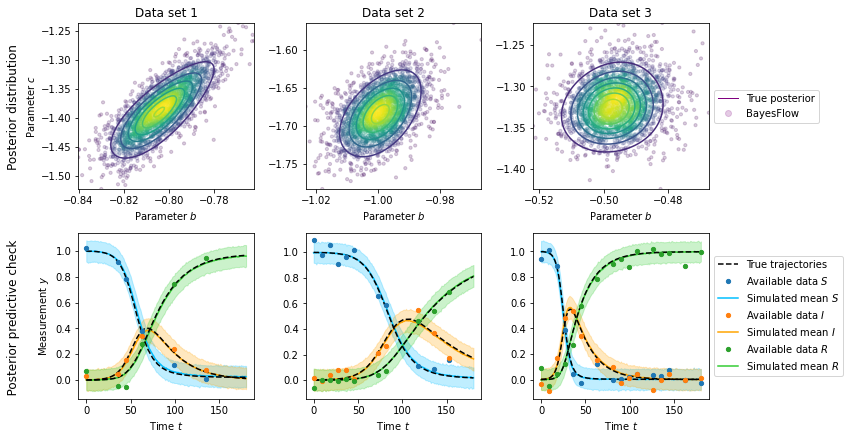

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6.2))

for j in range(len(x_datas)):
    
    # Posterior plot
    ax = axes[0,j]
    plot_posterior(ax, posteriors[j], param_samples[j], j+1)
    if j == 2:
        legend_elements = [
            Line2D([0], [0], color="purple", lw=1, label="True posterior"),
            Line2D([0], [0], color="purple", markerfacecolor="purple", marker="o", lw=0, markersize=6, alpha=0.2, label="BayesFlow"),
        ]
        ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))
    if j > 0:
        ax.set_ylabel(None) 
    
    # Predictive check
    ax = axes[1,j]
    plot_predictive_check(ax, param_priors[j], x_datas[j], param_samples[j])       
    if j == 2:
        handles, labels = ax.get_legend_handles_labels()
        order = [3,4,0,5,1,6,2]
        ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="center left", bbox_to_anchor=(1, 0.5))
    if j > 0:
        ax.set_ylabel(None)

fig.supylabel("   Posterior predictive check                  Posterior distribution   ")
fig.tight_layout()

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/SIR.{fmt}", dpi=300, bbox_inches='tight')